## Прогнозирование количества заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

# 1. Подготовка данных

Импортируем библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

Сохраним датасет в переменную `df`, приведем столбец с датой к формату datetime и сделаем его индексом таблицы:

In [2]:
df = pd.read_csv('taxi.csv', parse_dates = [0], index_col = 'datetime')
df.head(7)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7


Узнаем количество данных в датасете и тип данных в столбце `num_orders`:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим, что в датасете нет пропусков:

In [4]:
df.isna().sum()

num_orders    0
dtype: int64

Проверим, что данные расположены в хронологическом порядке:

In [5]:
df.index.is_monotonic

True

Выполним ресемплирование данных по 1 часу:

In [6]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Сохраним в отдельные столбцы месяц, день месяца, день недели и час:

In [7]:
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour
df.head()

,num_orders,month,day,dayofweek,hour
datetime,,,,,
2018-03-01 00:00:00,124,3,1,3,0
2018-03-01 01:00:00,85,3,1,3,1
2018-03-01 02:00:00,71,3,1,3,2
2018-03-01 03:00:00,66,3,1,3,3
2018-03-01 04:00:00,43,3,1,3,4


Исключим выбросы, которые могут ухудшить качество модели. В случаях, когда количество заказов превысило среднее за месяц более чем на 3 стандартных отклонения, заменим количество заказов этим значением (среднее + 3 стандартных отклонения):

In [8]:
for i in df.month.unique():
    order_mean = df[df.month == i].num_orders.mean()
    order_std = df[df.month == i].num_orders.std()
    print('Месяц:', i)
    print('Предельное значение:', round(order_mean + 3 * order_std))
    print('Выбросы:', df[(df.month == i) & (df.num_orders > (order_mean + 3 * order_std))])
    print()
    df.loc[df[(df.month == i) & (df.num_orders > (order_mean + 3 * order_std))].index, 'num_orders'] = order_mean + 3 * order_std

Месяц: 3
Предельное значение: 146
Выбросы:                      num_orders  month  day  dayofweek  hour
datetime                                                    
2018-03-03 00:00:00         163      3    3          5     0
2018-03-05 01:00:00         176      3    5          0     1
2018-03-12 01:00:00         153      3   12          0     1
2018-03-19 01:00:00         163      3   19          0     1
2018-03-24 00:00:00         148      3   24          5     0
2018-03-24 01:00:00         182      3   24          5     1
2018-03-26 01:00:00         176      3   26          0     1

Месяц: 4
Предельное значение: 160
Выбросы:                      num_orders  month  day  dayofweek  hour
datetime                                                    
2018-04-02 00:00:00       166.0      4    2          0     0
2018-04-06 22:00:00       176.0      4    6          4    22
2018-04-09 00:00:00       164.0      4    9          0     0
2018-04-16 00:00:00       165.0      4   16          0     

# 2. Анализ данных

Изучим распределение заказов во времени. Сначала посмотрим, как количество заказов зависит от времени суток и от дня недели:

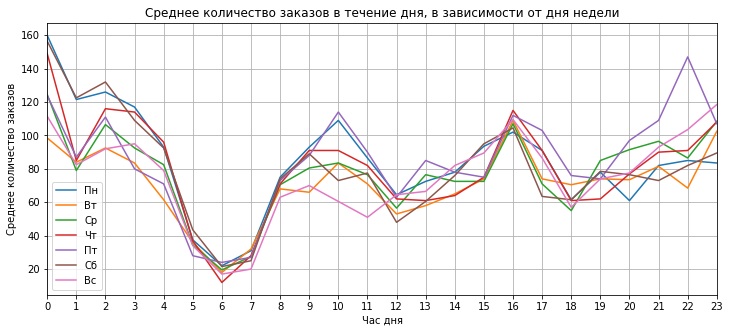

In [9]:
pd.crosstab(index = df.hour, columns = df.dayofweek, values = df.num_orders, aggfunc = 'median') \
            .plot(figsize = (12, 5), grid = True);
plt.xticks(np.arange(24))
plt.title('Среднее количество заказов в течение дня, в зависимости от дня недели')
plt.xlabel('Час дня')
plt.ylabel('Среднее количество заказов')
plt.legend(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']);

Как видим, есть ярко выраженная динамика количества заказов в течение дня: заметный спад ранним утром (5-7 утра) и всплески в начале рабочего дня, в послеобеденное время, вечером и после полуночи. 

Интересно, что в ночное время (в 2-4 ночи) заказов даже больше, чем вечером. Возможно, это связано с расписанием рейсов в аэропортах, а также с тем, что ночью люди с большей вероятностью воспользуются услугами такси, чем общественным транспортом.

При этом заметно, что количество заказов может значительно различаться в разные дни недели (иногда в 2 раза). Особенно заметен всплеск количества заказов в Пт вечером.

Теперь посмотрим на общую динамику количества заказов за полгода:

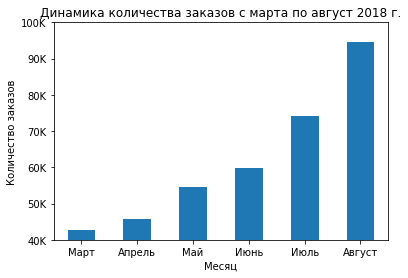

In [10]:
df.groupby('month').num_orders.sum().plot(kind = 'bar')
plt.title('Динамика количества заказов с марта по август 2018 г.')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.ylim([40000, 100000])
plt.xticks(np.arange(6), ["Март", "Апрель", "Май", "Июнь", "Июль", "Август"], rotation = 0)
plt.yticks(np.arange(40000, 110000, 10000), ['40K', '50K', '60K', '70K', '80K', '90K', '100K']);

Похоже, дела у "Чётенького такси" идут неплохо: за полгода количество заказов выросло более чем в 2 раза.

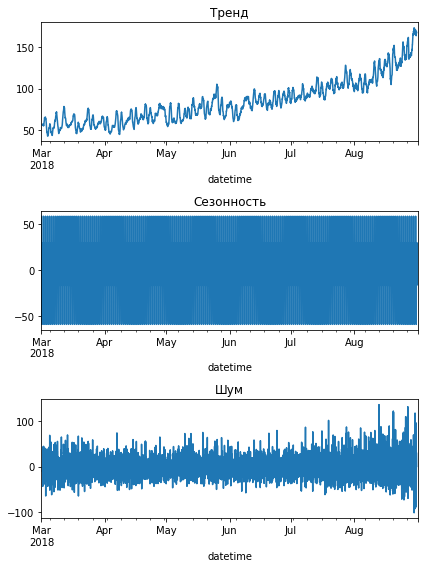

In [11]:
decomposed = seasonal_decompose(df.num_orders)
plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax = plt.gca())
plt.title('Шум')

plt.tight_layout()

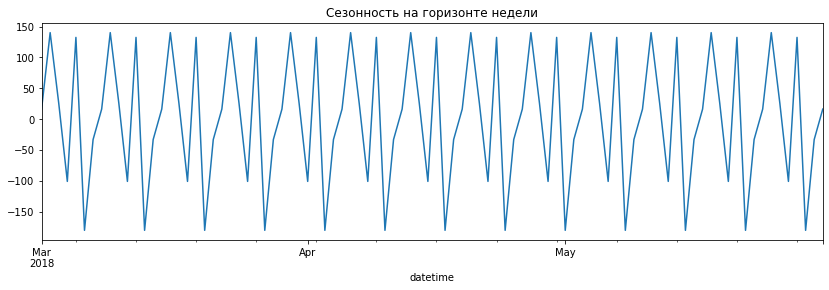

In [12]:
df_d = df.resample('1D').sum()
decomp_d = seasonal_decompose(df_d.num_orders)
decomp_d.seasonal['2018-03-01':'2018-05-31'].plot(figsize = (14, 4))
plt.title('Сезонность на горизонте недели');

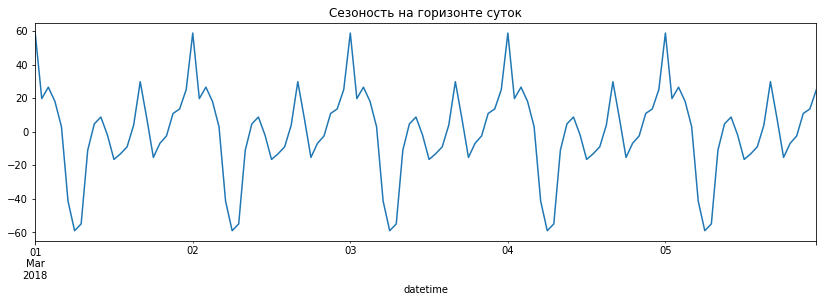

In [13]:
decomposed.seasonal['2018-03-01':'2018-03-05'].plot(figsize = (14, 4))
plt.title('Сезоность на горизонте суток');

Нам нужно обучить модель, которая сможет с высокой точностью предсказывать количество заказов с учетом общего тренда и закономерностей распределения заказов внутри недели и дня.

# 3. Обучение

Сформируем дополнительные признаки: 
    - отстающие значения, которые подскажут, будет целевой признак расти или уменьшаться
    - скользящее среднее, которое задаст общий тренд временного ряда.
    
Напишем функцию:

In [14]:
def make_features(data, target, max_lag, rolling_mean_size):
# отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[target].shift(lag)
# скользящее среднее
    data['rolling_mean'] = data[target].shift(1).rolling(rolling_mean_size).mean()

Применим функцию:

In [15]:
make_features(df, 'num_orders', 24, 24)

Визуализируем общий тренд с использованием скользящего среднего:

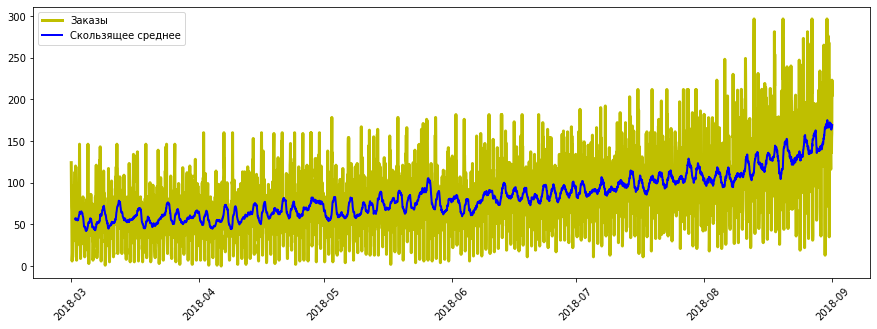

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df.index, df.num_orders, color='y', lw=3, label = 'Заказы')
ax.plot(df.index, df.rolling_mean, color='b', lw=2, label = 'Скользящее среднее')
plt.legend()
plt.xticks(rotation = 45);

Выделим тестовую выборку (10% от исходных данных):

In [17]:
train, test = train_test_split(df, shuffle = False, test_size = 0.1)
train.index.max(), test.index.min()

(Timestamp('2018-08-13 13:00:00'), Timestamp('2018-08-13 14:00:00'))

Исключим пропуски, которые образовались в первых строках датасета при создании отстающих значений, а затем выделим признаки и целевой признак для обучения и тестирования моделей:

In [18]:
train = train.dropna()
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

Масштабируем числовые признаки:

In [19]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

Напишем функции для визуализации предсказаний модели и важности признаков:

In [20]:
def vizual_pred(y_test, y_pred, model_name):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(y_test.index, y_test, color='y', lw=3, label = 'Ответы')
    ax.plot(y_test.index, y_pred, color='r', lw=2, label = 'Предсказания')
    plt.legend()
    plt.xticks(rotation = 45)
    plt.title('Предсказания модели: {}'.format(model_name))
    plt.show()

In [21]:
def vizual_fimp(model_cv, X_train, model_name):
    fimp = round(pd.Series(model_cv.best_estimator_.feature_importances_, index = X_train.columns), 4)
    fimp = fimp.sort_values(ascending = False)
    fimp.plot(kind = 'bar', figsize = (12, 4))
    plt.title('Важность признаков в модели: {}'.format(model_name))
    plt.xlabel("Признаки")
    plt.ylabel("Важность признака")
    plt.xticks(rotation = 45);

Обучим несколько моделей, подберем гиперпараметры и сравним RMSE на тестовой выборке:

## 3.1. Случайный лес

In [22]:
%%time

ranfor = RandomForestRegressor(random_state = 123)
params = {'max_depth': range(27, 38, 5), 'n_estimators': range(500, 750, 100)}
mycv = TimeSeriesSplit(n_splits=3)
rf = GridSearchCV(ranfor, param_grid = params, scoring = 'neg_mean_squared_error', cv = mycv, n_jobs = -1)

# обучим модель и выведем оптимальную глубину дерева и наилучший RMSE на кросс-валидации
rf.fit(X_train_s, y_train)
print('Оптимальная глубина дерева:', rf.best_params_['max_depth'])
print('Оптимальное количество деревьев:', rf.best_params_['n_estimators'])
print('Лучший RMSE на кросс-валидации:', abs(rf.best_score_) ** 0.5)

# получим предсказания модели на тестовой выборке и посчитаем RMSE
rf_pred = rf.predict(X_test_s)
print('RMSE на тестовой выборке:', mean_squared_error(y_test, rf_pred) ** 0.5)

Оптимальная глубина дерева: 37
Оптимальное количество деревьев: 500
Лучший RMSE на кросс-валидации: 26.250675435958723
RMSE на тестовой выборке: 40.65467384512635
CPU times: user 10min 6s, sys: 900 ms, total: 10min 7s
Wall time: 10min 23s


Оптимальная глубина дерева: 37

Оптимальное количество деревьев: 500

Лучший RMSE на кросс-валидации: 26.250675435958723

RMSE на тестовой выборке: 40.65467384512635

CPU times: user 10min 15s, sys: 1.42 s, total: 10min 17s

Wall time: 10min 27s

Визуализируем предсказания модели в сравнении с реальной динамикой заказов на тестовой выборке:

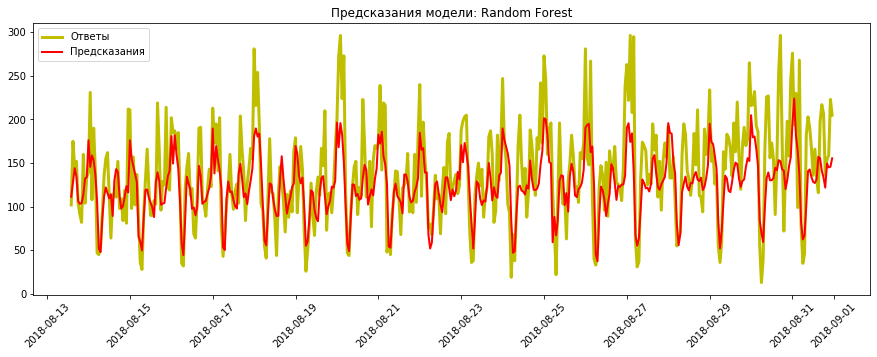

In [23]:
vizual_pred(y_test, rf_pred, 'Random Forest')

Визуализируем важность разных признаков:

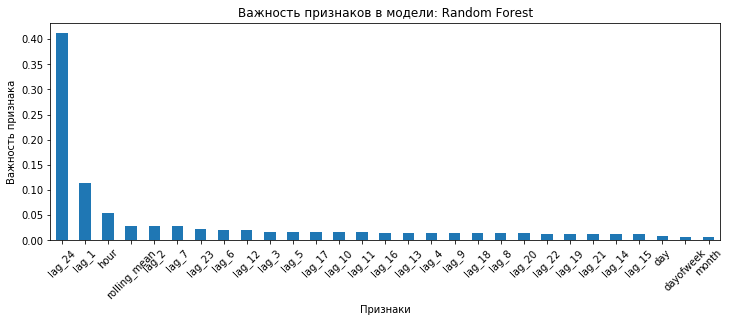

In [24]:
vizual_fimp(rf, X_train, 'Random Forest')

## 3.2. Градиентный бустинг

! Следующие ячейки закомментированы, т.к. модель обучается слишком долго. Результаты модели ниже.

In [25]:
# %%time
# params = {'learning_rate': [0.01, 0.1, 1], 'max_depth': range(15, 36, 10), 'n_estimators': [500, 600, 700]}
# gbmс = LGBMRegressor(random_state = 123, importance_type = 'gain')
# my_cv = TimeSeriesSplit(n_splits = 3)
# gs_gbmс = GridSearchCV(gbmс, param_grid = params, scoring = 'neg_mean_squared_error', cv = my_cv, n_jobs = -1)
# gs_gbmс.fit(X_train_s, y_train)

# print('Оптимальные параметры:', gs_gbmс.best_params_)
# print('Лучший RMSE на кросс-валидации:', abs(gs_gbmс.best_score_) ** 0.5)

# gs_gbmс_pred = gs_gbmс.predict(X_test_s)
# print('RMSE на тестовой выборке:', mean_squared_error(y_test, gs_gbmс_pred) ** 0.5)

Оптимальные параметры: {'learning_rate': 0.01, 'max_depth': 25, 'n_estimators': 600}

Лучший RMSE на кросс-валидации: 25.66241720985858

RMSE на тестовой выборке: 39.67165896607768

CPU times: user 1h 43min 29s, sys: 43.5 s, total: 1h 44min 12s

Wall time: 1h 45min 4s

Визуализируем предсказания модели в сравнении с реальной динамикой заказов на тестовой выборке:

In [26]:
# vizual_pred(y_test, gs_gbmс_pred, 'LightGBM')

Визуализируем важность разных признаков:

In [27]:
# vizual_fimp(gs_gbmс, X_train, 'LightGBM')

## 3.3. Линейная регрессия с регуляризацией Ridge

In [28]:
%%time

ridge_model = Ridge(random_state = 123)
my_cv = TimeSeriesSplit(n_splits = 3)
pars = {'alpha': [0.1, 1], 'max_iter': [500, 1000]}
ridge = GridSearchCV(ridge_model, param_grid = pars, scoring = 'neg_mean_squared_error', cv = my_cv, n_jobs = -1)
ridge.fit(X_train_s, y_train)
ridge_pred = ridge.predict(X_test_s)
print('Лучший RMSE на кросс-валидации:', abs(ridge.best_score_) ** 0.5)
print('RMSE на тестовой выборке:', mean_squared_error(y_test, ridge_pred) ** 0.5)

Лучший RMSE на кросс-валидации: 26.857290464402578
RMSE на тестовой выборке: 41.58487390847959
CPU times: user 189 ms, sys: 187 ms, total: 376 ms
Wall time: 291 ms


Лучший RMSE на кросс-валидации: 26.857500272080358
    
RMSE на тестовой выборке: 41.58684159129508
    
CPU times: user 595 ms, sys: 509 ms, total: 1.1 s
            
Wall time: 1.08 s

Визуализируем предсказания модели в сравнении с реальной динамикой заказов на тестовой выборке:

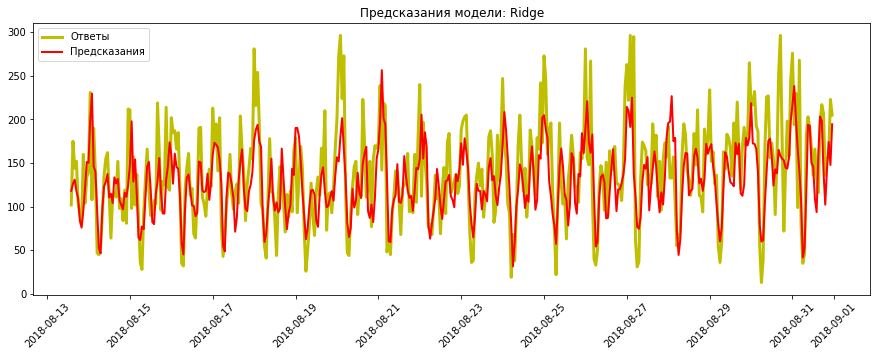

In [29]:
vizual_pred(y_test, ridge_pred, 'Ridge')

Визуализируем коэффициенты, которые модель присвоила разным признакам:

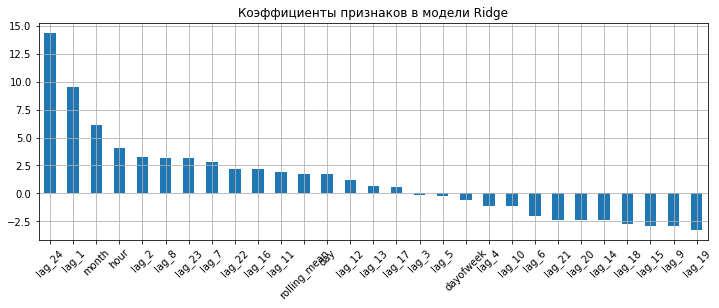

In [30]:
pd.Series(ridge.best_estimator_.coef_, index = X_train.columns).sort_values(ascending = False).plot(kind = 'bar', figsize = (12, 4))
plt.title('Коэффициенты признаков в модели Ridge')
plt.grid(True)
plt.xticks(rotation = 45);

Сведем результаты в таблицу:

In [31]:
results = [['RandomForest', 26.25, 40.65, 10.27],  \
           ['LightGBM', 25.66, 39.67, 105.4], ['Ridge', 26.85, 41.58, 0.016],]
table = pd.DataFrame(results, columns = ['Model', 'RMSE (cv)', 'RMSE (test)', 'Time'])
table

,Model,RMSE (cv),RMSE (test),Time
0,RandomForest,26.25,40.65,10.270
1,LightGBM,25.66,39.67,105.400
2,Ridge,26.85,41.58,0.016


Результаты моделей, обученных на признаках **"day_of_week", "hour", "lag_1", "lag_2", "rolling_mean":**

In [32]:
results2 = [['RandomForest', 26.72, 43.34, 2],  \
           ['LightGBM', '-', '-', '-'], ['Ridge', 32.12, 48.47, 0],]
table2 = pd.DataFrame(results2, columns = ['Model', 'RMSE (cv)', 'RMSE (test)', 'Time'])
table2

,Model,RMSE (cv),RMSE (test),Time
0,RandomForest,26.72,43.34,2
1,LightGBM,-,-,-
2,Ridge,32.12,48.47,0


Результаты моделей, обученных на признаках **"month", "day", "day_of_week", "hour", "lag_1", "lag_2", "rolling_mean":**

In [33]:
results3 = [['RandomForest', 26.25, 40.65, 10],  \
           ['LightGBM', '-', '-', '-'], ['Ridge', 31.86, 49.38, 0],]
table3 = pd.DataFrame(results3, columns = ['Model', 'RMSE (cv)', 'RMSE (test)', 'Time'])
table3

,Model,RMSE (cv),RMSE (test),Time
0,RandomForest,26.25,40.65,10
1,LightGBM,-,-,-
2,Ridge,31.86,49.38,0


Результаты моделей, обученных на признаках **"month", "day", "day_of_week", "hour", "lag_1", "lag_24", "rolling_mean":**

In [34]:
results4 = [['RandomForest', 26.12, 43.5, 2],  \
           ['LightGBM', '-', '-', '-'], ['Ridge', 27.5, 43.17, 0],]
table4 = pd.DataFrame(results4, columns = ['Model', 'RMSE (cv)', 'RMSE (test)', 'Time'])
table4

,Model,RMSE (cv),RMSE (test),Time
0,RandomForest,26.12,43.5,2
1,LightGBM,-,-,-
2,Ridge,27.5,43.17,0


## Выводы

- Все алгоритмы показали примерно одинаковые результаты (RMSE).

LightGBM обучается очень долго, но показывает лучший результат. Ridge обучается мгновенно, но показывает результат чуть хуже, чем другие модели. Но разница в RMSE трех моделей минимальна.

- На графиках с предсказаниями моделей видно, что в целом все модели неплохо предсказывают, опираясь на закономерности в распределении заказов в течение дня и недели. 

При этом модели плохо справляются с предсказанием значений, сильно отклоняющихся от нормы. Эти всплески и спады могут быть вызваны внешними факторами, которые сложно или невозможно предсказать заранее.

- Важность признаков в разных моделях похожа: наибольший вес имеют признаки 'lag_24', 'lag_1' и 'hour'. 

Это кажется логичным: алгоритмы выявили закономерности в распределении заказов в течение дня. Те самые, которые мы обнаружили на этапе анализа данных.

В модели Ridge достаточно высокий коэффициент имеет также признак Month. Глядя на график, кажется, что эта модель почти смогла предсказать восходящий тренд, который прослеживается в последних числах августа. 

Среднее количество заказов в предсказаниях модели Ridge ближе всего к истине:

In [35]:
print('Средние значения')
print()
print('На тестовой выборке:', round(y_test.mean()))
print('Предсказания модели Random Forest:', round(rf_pred.mean()))
#print('Предсказания модели LightGBM:', round(gs_gbmс_pred.mean()))
print('Предсказания модели LightGBM:', 123)
print('Предсказания модели Ridge:', round(ridge_pred.mean()))

Средние значения

На тестовой выборке: 139
Предсказания модели Random Forest: 125
Предсказания модели LightGBM: 123
Предсказания модели Ridge: 130
